In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import time
import csv
import random
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import keras
from keras.layers import Flatten, Input, Dense
from keras.layers import Dropout, Conv1D, Activation, MaxPooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [2]:
#load datasets
def get_datasets(diseases, nr_inputs=260):
    datasets = []
    sample_dir = "datasets/samples"
    for idx, disease in enumerate(diseases):
        dataset_dir = os.path.join(sample_dir, str(idx))
        datasets.append([])
        for record in sorted(os.listdir(dataset_dir)):
            record_path = os.path.join(dataset_dir, record)
            with open(record_path) as dis:
                dataset = np.loadtxt(dis)
                if len(dataset) != nr_inputs:
                    print(len(dataset), nr_inputs)
                    continue
                datasets[idx].append(dataset)
    return datasets

In [3]:
def normalize_data(datasets):
    normalized=[]
    for case in datasets:
        cases=[]
        for data in case:
            mu = np.mean(data)
            sigma = np.std(data)
            #fixed = (np.array(data) - mu) / sigma
            fixed = stats.zscore(data)
            cases.append(fixed - min(fixed))
        normalized.append(cases) 
    return normalized

In [4]:
def generate_data(data):
    s_thd = np.random.uniform(low=0.05, high=0.15, size=None)
    m_thd = np.random.uniform(low=-0.2, high=0.2, size=None)
    mu, sigma = np.mean(data), np.std(data)
    noise = np.random.normal(mu, sigma, [data.shape[0],]) * s_thd + m_thd
    fixed = data + noise
    return fixed-min(fixed)

In [5]:
def generate_datasets(datasets, data_length):
    generate_data_num = [max(data_length) - x for x in data_length]
    for idx, num in enumerate(generate_data_num):
        for i in range(num):
            target_idx = np.random.randint(data_length[idx], size=None)
            target_data = datasets[idx][target_idx]
            datasets[idx].append(generate_data(target_data).tolist())
    return datasets

In [6]:
def split_train_valid(datasets, split=0.9):
    data_length = [len(x) for x in datasets]
    train_length = int(min(data_length) * split)
    train_data = [x[:train_length] for x in datasets]
    valid_data = [x[train_length:] for x in datasets]
    return train_data, valid_data

In [7]:
def get_label(data):
    label= [[idx]*len(x) for idx, x in enumerate(data)]
    label= label[0]+label[1]+label[2]+label[3]+label[4]
    return label

In [8]:
def get_cnn_model(filter_num,filter_size, num_classes=5, 
                  activation='relu', maxpool_size=2, dim=260):
    
    cnn_model = Sequential()
    cnn_model.add(Conv1D (kernel_size=filter_size,
                          filters=filter_num, 
                          input_shape=(dim,1)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Conv1D(kernel_size=filter_size,
                         filters=filter_num))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(MaxPooling1D(pool_size=(maxpool_size)))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(20))
    cnn_model.add(Activation(activation))
    cnn_model.add(Dense(num_classes))
    cnn_model.add(Activation('softmax'))
    return cnn_model

In [9]:
def fit_model(model, x_train, y_train, x_test, y_test, opt, 
             batch_size=32, epochs=20, shuffle=True,
             loss='categorical_crossentropy',
             metrics=['accuracy'], verbose=0):
    
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=shuffle,
                       verbose=verbose)
    return history

In [10]:
def get_predict(model, datasets):
    predict_list = []
    for case in datasets:
        predict_case=[]
        for data in case:
            data = np.expand_dims(data,1)
            rs = np.argmax(model.predict(np.expand_dims(data,0)))
            predict_case.append(rs)
        predict_list.append(predict_case)
    return predict_list

def get_predict_numpy(model, datasets):
    predict_list = []
    for data in datasets:
        rs = np.argmax(model.predict(np.expand_dims(data,0)))
        predict_list.append(rs)
    return predict_list

In [11]:
def get_total_num(y_true, y_pred, label_num):
    total_nums=[]
    for a in range(label_num):
        nums=[]
        idx = np.array(y_true)==a
        for case in range(label_num):
            nums.append(sum(np.array(y_pred)[idx]==case))
        total_nums.append(nums)
    return total_nums

In [12]:
np.random.seed(0)
heart_diseases = ['N', 'S', 'V', 'F', 'Q']
num_classes=5

In [14]:
datasets = get_datasets(heart_diseases)
datasets = normalize_data(datasets)
datasets = [x[:9000] for x in datasets]
data_length = [len(x) for x in datasets]
datasets = generate_datasets(datasets, data_length)
generated_data_length = [len(x) for x in datasets]

In [15]:
train_data = datasets
train_label = get_label(train_data)
train_data = [x for case in train_data for x in case]
train_data = np.reshape(train_data, (len(train_data), 260, 1))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    train_label,
                                                    train_size=0.8)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
valid_data = datasets
valid_label = get_label(valid_data)
valid_label = keras.utils.to_categorical(valid_label, num_classes)

In [20]:
#test case of filter size
filter_size=[4,8,12]
#test case of filter num
filter_num=[8,16,32]
#test epochs
epochs=20
#learning rate
lr=0.01
#optimizer
opt = keras.optimizers.rmsprop(lr=lr, decay=1e-6)

#history
rs_history=[]
#model
rs_model=[]
#pred
rs_pred=[]
#report
rs_report=[]

for size in filter_size:
    for num in filter_num:
        print("======================================================")

        ##############################
        #get cnn model
        model = get_cnn_model(filter_num=num ,filter_size=size)
        print()
        print('[filter num]{}  [filter size]{}'.format(num,size))
        print("------------------------------------------------------")
        
        ##############################
        #compile and fit model
        print(">>fitting model..")
        history = fit_model(model=model, 
                            x_train=x_train,
                            y_train=y_train,
                            x_test=x_test,
                            y_test=y_test,
                            opt=opt,
                            epochs=epochs,
                            verbose=0,
                            )
        print(">>fitting complete")
        
        ##############################
        #predict label
        print(">>predict model..")
        '''
        predict_list = get_predict(model, valid_data)
        true_list = [[idx]*len(x) for idx,x in enumerate(predict_list)]
        flatten_predict = [x for case in predict_list for x in case]
        flatten_true = [x for case in  true_list for x in case]
        '''
        predict_list = get_predict_numpy(model, x_test)
        print(">>predict complete")
        
        ##############################
        #data evaluation score
        #label/list | precision | recall | f1-score | support
        #       0 |       
        #       1 |
        #       2 |               score                 num
        #       3 |
        #       4 |  
        print()
        print("[scores]")
        print("------------------------------------------------------")
        flatten_true=[np.argmax(x) for x in y_test]
        flatten_predict=predict_list
        r_nums = get_total_num(y_true=flatten_true,
                              y_pred=flatten_predict,
                              label_num=len(heart_diseases))
        report = classification_report(flatten_true, 
                                    flatten_predict,
                                    target_names=heart_diseases, 
                                    digits=4,
                                    output_dict=True)
        print(report)
        
        ##############################
        #label/pred | 0 | 1 | 2 | 3 | 4 |
        #  0 |                          => sum()=datasets num
        #  1 |                          => sum()=datasets num
        #  2 |         data num         => sum()=datasets num
        #  3 |                          => sum()=datasets num
        #  4 |                          => sum()=datasets num
        ##############################
        print()
        print('[y:origin | x:prediction]')
        print("------------------------------------------------------")
        for r in r_nums:
            print(r)
            

        
        ##############################
        #save result
        ##############################
        print()
        print('[save result]')
        print("------------------------------------------------------")
        rs_history.append(history)
        rs_model.append(model)
        rs_pred.append(flatten_predict)
        rs_report.append(report)
        
        print("======================================================")
        print("\n\n")


[filter num]8  [filter size]4
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
------------------------------------------------------
{'S': {'support': 1725, 'recall': 0.9756521739130435, 'precision': 0.9853629976580797, 'f1-score': 0.9804835420914652}, 'weighted avg': {'support': 9000, 'recall': 0.9771111111111112, 'precision': 0.9774112846334544, 'f1-score': 0.9771317638636273}, 'Q': {'support': 1805, 'recall': 0.9905817174515236, 'precision': 0.994991652754591, 'f1-score': 0.9927817878956136}, 'N': {'support': 1809, 'recall': 0.9917081260364843, 'precision': 0.975, 'f1-score': 0.9832830912578789}, 'micro avg': {'support': 9000, 'recall': 0.9771111111111112, 'precision': 0.9771111111111112, 'f1-score': 0.9771111111111112}, 'V': {'support': 1791, 'recall': 0.9765494137353434, 'precision': 0.9459167117360735, 'f1-score': 0.9609890109890111}, 'macro avg': {'support': 9000, 'recall': 0.977272617778


[filter num]8  [filter size]12
------------------------------------------------------
>>fitting model..
>>fitting complete
>>predict model..
>>predict complete

[scores]
------------------------------------------------------
{'S': {'support': 1725, 'recall': 0.9884057971014493, 'precision': 0.978760045924225, 'f1-score': 0.9835592731468128}, 'weighted avg': {'support': 9000, 'recall': 0.9816666666666667, 'precision': 0.9816663023359765, 'f1-score': 0.9816565627067478}, 'Q': {'support': 1805, 'recall': 0.9911357340720222, 'precision': 0.9944413563090606, 'f1-score': 0.9927857935627081}, 'N': {'support': 1809, 'recall': 0.9906025428413489, 'precision': 0.9862410566868465, 'f1-score': 0.9884169884169884}, 'micro avg': {'support': 9000, 'recall': 0.9816666666666667, 'precision': 0.9816666666666667, 'f1-score': 0.9816666666666667}, 'V': {'support': 1791, 'recall': 0.9692908989391401, 'precision': 0.970917225950783, 'f1-score': 0.9701033808326348}, 'macro avg': {'support': 9000, 'recall': 0

In [38]:

#test case of filter size
filter_size=[4,8,12]
#test case of filter num
filter_num=[8,16,32]
print(rs_report[0].keys())
print(rs_report[0]['S'].keys())
print(rs_report[0]['S']['recall'])


dict_keys(['S', 'weighted avg', 'Q', 'N', 'micro avg', 'V', 'macro avg', 'F'])
dict_keys(['support', 'recall', 'precision', 'f1-score'])
0.9756521739130435


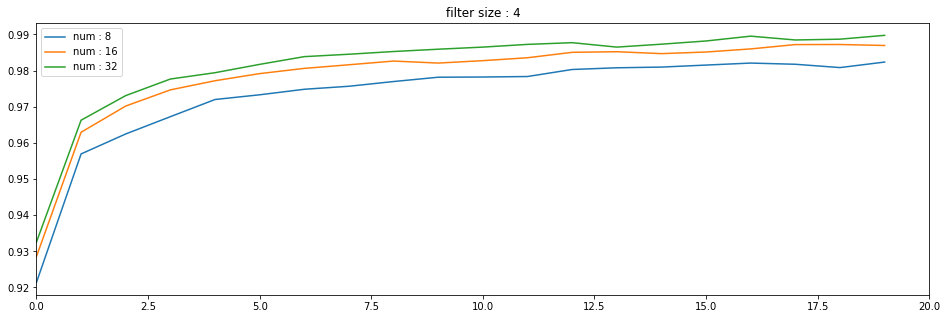

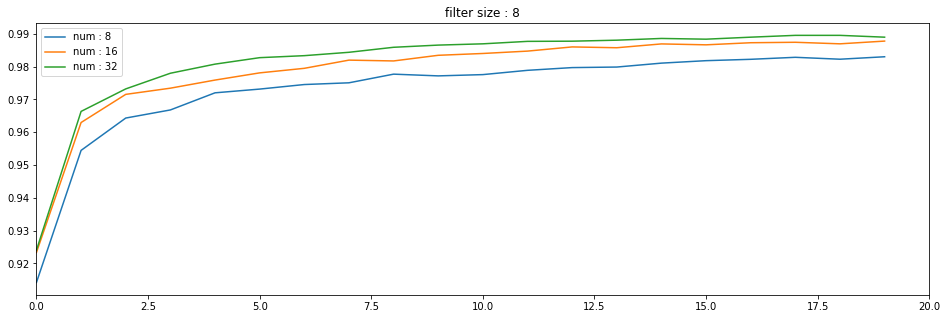

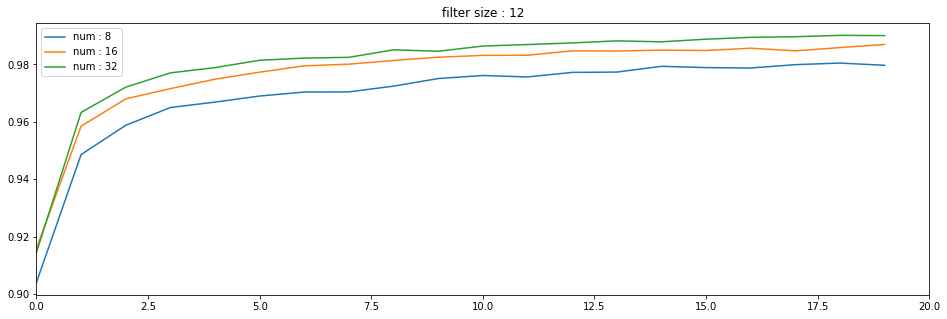

In [91]:
##acc graph
for idx in range(len(filter_size)):
    fig = plt.figure(figsize=(16,5))
    plt.title("filter size : {}".format(filter_size[idx]))
    plt.plot(rs_history[idx*3].history['acc'], 
             label="num : {}".format(filter_num[0]))
    plt.title("filter size : {}".format(filter_size[idx]))
    plt.plot(rs_history[idx*3+1].history['acc'], 
             label="num : {}".format(filter_num[1]))
    plt.title("filter size : {}".format(filter_size[idx]))
    plt.plot(rs_history[idx*3+2].history['acc'], 
             label="num : {}".format(filter_num[2]))
    plt.xlim((0, 20))
    plt.legend()
    plt.show()

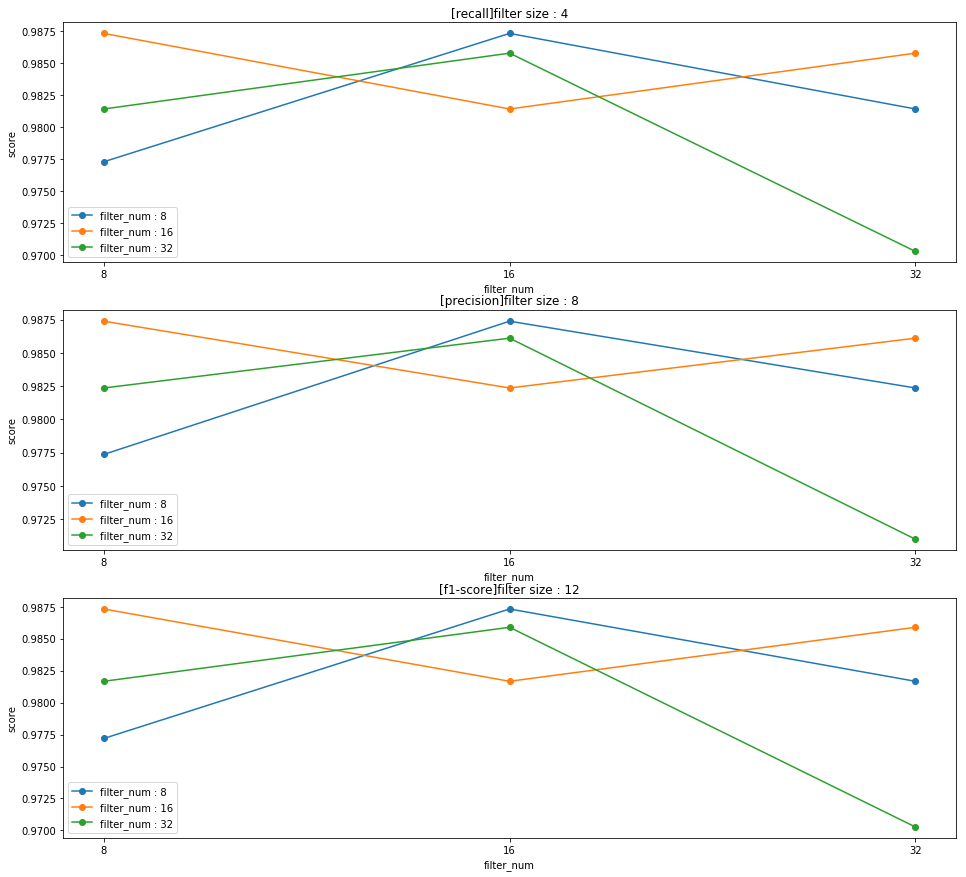

In [93]:
fig = plt.figure(figsize=(16,15))
for step, key in enumerate(['recall', 'precision', 'f1-score']):
    plt.subplot(3,1,step+1)
    for idx in range(3):
        
        plt.title("[{}]filter size : {}".format(key, filter_size[step]))
        plt.xlabel('filter_num')
        plt.ylabel('score')
        
        a1 = np.mean([rs_report[idx][x][key] for x in heart_diseases])
        a2 = np.mean([rs_report[idx+1][x][key] for x in heart_diseases])
        a3 = np.mean([rs_report[idx+2][x][key] for x in heart_diseases])

        y = [a1,a2,a3]
        
        plt.plot(['8','16','32'],y,'o-')
        plt.legend(['filter_num : 8','filter_num : 16','filter_num : 32'])
        
plt.show()